<a href="https://colab.research.google.com/github/sg2083/vis/blob/main/data_viz_ps4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analyzing Global Food Prices and Inflation Trends**

#### **Abstract**

Food prices and inflation are two critical economic indicators that shape global markets, policymaking, and household consumption. Over recent decades, food prices have exhibited significant volatility, influenced by climate change, supply chain disruptions, geopolitical events, and economic policies. This project seeks to explore the relationship between food price inflation and general inflation trends, providing insights that can assist governments, businesses, and consumers in making informed decisions on food security and economic stability.

To achieve this, datasets have been integrated from multiple global sources, including the Food and Agriculture Organization (FAO) and the World Bank.

#### **Key Research Questions**

1. How do food price indices (both nominal and real) correlate with general inflation rates?
2. What are the trends and patterns in food price fluctuations across different food categories?
3. Can we identify historical periods of high food price inflation, and what economic factors contributed to these trends?

#### **Hypotheses**

- **H1:** There is a positive correlation between food price indices and general inflation.
- **H2:** Inflation-adjusted food prices (real FPI) show less volatility than nominal food prices.
- **H3:** Different food categories (meat, dairy, cereals, oils, sugars) exhibit distinct inflationary trends based on global economic conditions.

### **Data Sources & Variables**

The following three datasets, sourced from different platforms, have been integrated and uploaded to the GitHub repository, from which they will be accessed for analysis.

1. **[Food Price Index (FPI) Data (FAO)](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/)** ‚Äì Includes annual indices for food prices and subcategories (cereals, dairy, etc.), capturing both nominal and real values.
   - **URL:** [FAO FPI Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx)
   - **Key Variables:** Year, Food Price Index, Meat, Dairy, Cereals, Oils, Sugars
2. **[World Bank Inflation Data](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG)** ‚Äì Provides annual CPI-based inflation rates for multiple countries, aggregated into a global average.
   - **URL:** [World Bank Inflation Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/inflation_cpi_data.csv)
   - **Key Variables:** Year, Inflation Rate
3. **[Nominal vs Real Food Price Index (FAO)](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/)** ‚Äì Differentiates between nominal and inflation-adjusted food price indices.
   - **URL:** [FAO Nominal vs Real FPI Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json)
   - **Key Variables:** Year, Nominal Index, Real Index

In [158]:
import pandas as pd
import numpy as np
import json
import requests
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os, zipfile
import geopandas as gpd
from shapely.geometry import Point
# Load the datasets
fpi_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx"
inflation_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/inflation_cpi_data.csv"
nominal_real_fpi_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json"

fpi_data = pd.read_excel(fpi_url, sheet_name="Annual", skiprows=1, engine="openpyxl")
food_inflation_data = pd.read_csv(inflation_url, skiprows=4)
response = requests.get(nominal_real_fpi_url) # fetch the data from the URL
nominal_real_fpi_data = json.loads(response.text)  # load the JSON data from the response

nominal_real_fpi_df = pd.DataFrame(nominal_real_fpi_data['FFPI_Historical'])


### **Data Processing Steps**

#### **1. Data Cleaning and Transformation**

- **Renamed Variables**: Standardized column names across datasets for consistency.
- **Dropped Irrelevant Columns**: Retained only necessary columns such as Year, Inflation Rate, and Food Price Indices.
- **Replaced Values**: Forward-filled missing inflation rates where necessary.
- **Reshaped Data**: Converted World Bank inflation data from wide to long format.

In [159]:
food_inflation_data = pd.melt(food_inflation_data, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                        var_name='Year', value_name='Inflation Rate')

# Display the first few rows of the reshaped inflation data
print(food_inflation_data.head())


                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                          Indicator Name  Indicator Code  Year  Inflation Rate  
0  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
1  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
2  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
3  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
4  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  


In [160]:
food_inflation_data.rename(columns={"Country Name": "country_name", "Year": "year", "Inflation Rate": "Food_CPI_inflation_rate"}, inplace=True)
print("After Renaming Variables")
print(food_inflation_data.columns)

After Renaming Variables
Index(['country_name', 'Country Code', 'Indicator Name', 'Indicator Code',
       'year', 'Food_CPI_inflation_rate'],
      dtype='object')


In [161]:
# Dataset-2: Processing Food Price Index (FPI) Categories

# Rename columns
fpi_data.columns = ["year", "food_price_index", "meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"]

# Remove invalid rows & Convert Year to integer
fpi_data.columns = fpi_data.columns.str.strip()
fpi_data_df = fpi_data[pd.to_numeric(fpi_data["year"], errors="coerce").notna()]
fpi_data_df["year"].astype(int)

print("FPI categories data processed!")
print(fpi_data_df.head(5))

FPI categories data processed!
   year food_price_index meat_index dairy_index cereals_index oils_index  \
1  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
2  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
3  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
4  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
5  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  
1    77.687305  
2    55.480618  
3    56.042747  
4    62.030198  
5    74.943701  


In [162]:
# Dataset-3: Processing FPI Nominal vs Real Data

# Rename columns for consistency
nominal_real_fpi_df = nominal_real_fpi_df.rename(columns={"Month": "year", "Nominal": "nominal_index", "Real": "real_index"})

# Ensure Year column is numeric
nominal_real_fpi_df["year"] = pd.to_numeric(nominal_real_fpi_df["year"], errors="coerce")

# Drop rows where Year is missing
nominal_real_fpi_df.dropna(subset=["year"], inplace=True)

# Strip spaces from column names
nominal_real_fpi_df.columns = nominal_real_fpi_df.columns.str.strip()

print("FPI Nominal vs Real data processed!")
print(nominal_real_fpi_df.head(5))

FPI Nominal vs Real data processed!
   year  nominal_index  real_index
0  1961      20.351527  104.336923
1  1962      20.096067  101.139987
2  1963      21.005116  107.687702
3  1964      21.989470  111.178294
4  1965      22.183831  111.092339


#### **2. Data Integration & Aggregation**

- **Merge 1:** Combined **Food Price Index (FPI) Data** with **World Bank Inflation Data** using Year as the common key.
- **Merge 2:** Integrated the **Nominal vs Real Food Price Index Data** into the merged dataset.
- **Aggregation:** Computed global average food inflation per year.

In [163]:
!pip install fuzzywuzzy

In [164]:
# Aggregate Global Inflation (Average across all countries per Year)
from fuzzywuzzy import process
weighted_gpd_countries_url = "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/gdp_weighted_share.xls"

weighted_gpd_countries = pd.read_excel(weighted_gpd_countries_url)
weighted_gpd_countries = pd.melt(weighted_gpd_countries, id_vars=['GDP based on PPP, share of world (Percent of World)',],
                        var_name='Year', value_name='Weighted_GDP_share')

weighted_gpd_countries.rename(columns={"Weighted_GDP_share": "GDP_Share", "Year": "year", "GDP based on PPP, share of world (Percent of World)": "country_name"}, inplace=True)

country_name_mapping = {
    "American Samoa":"Samoa",
    "Middle income": "Middle East and Central Asia",
    "Europe & Central Asia":"Europe",
    "North Macedonia":"North Macedonia ",
    "Middle East & North Africa": "North Africa",
    "Syrian Arab Republic": "Syria",
    "East Asia & Pacific": "East Asia",
    "Caribbean small states":"Caribbean",
    "St. Kitts and Nevis":"Saint Kitts and Nevis",
    "Latin America & Caribbean": "Latin America and the Caribbean",
     "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Lucia": "Saint Lucia",
    "Viet Nam": "Vietnam",
    "Micronesia, Fed. Sts.": "Micronesia, Fed. States of",
    "Korea, Rep.": "Korea, Republic of",
    "Egypt, Arab Rep.": "Egypt",
    "C√¥te d'Ivoire": "Cote d'Ivoire",
    "S√£o Tom√© and Pr√≠ncipe": "Sao Tome and Principe",
    "Iran, Islamic Rep.": "Iran",
    "Yemen, Rep.": "Yemen",
    "Venezuela, RB": "Venezuela",
    "Hong Kong SAR, China": "Hong Kong SAR",
    "Lao PDR": "Lao P.D.R.",
    "Macao SAR, China": "Macao SAR",
    "Czechia": "Czech Republic",
    "Turkiye": "T√ºrkiye, Republic of",
    "Syria, Arab Republic": "Syria",
    "Congo, Dem. Rep.": "Congo, Dem. Rep. of the",
    "Congo, Rep.": "Congo, Republic of",
    "Russia": "Russian Federation"
}

# Apply corrections to the dataset before merging
food_inflation_data["country_name"] = food_inflation_data["country_name"].replace(country_name_mapping)

# Merge datasets on Country Name & Year
missing_countries = set(food_inflation_data["country_name"]) - set(weighted_gpd_countries["country_name"])
print("Countries that did not merge:", len(missing_countries))
# for country in missing_countries:
#     match = process.extractOne(country, weighted_gpd_countries["country_name"])
#     print(f"Closest match for {country}: {match}")

# Exclude Non-Countries from Merging
# Some rows in your dataset are income groups or regions (not actual countries).
# To remove them before merging, filter them out:

non_countries = [
    "World", "High income", "Low income", "Middle income",
    "East Asia & Pacific", "Europe & Central Asia", "Latin America & Caribbean",
    "Middle East & North Africa", "Sub-Saharan Africa",
    "Euro area", "OECD members"
]

food_inflation_data = food_inflation_data[~food_inflation_data["country_name"].isin(non_countries)]

# Count duplicates in GDP Share dataset
print(weighted_gpd_countries.duplicated(subset=["country_name", "year"]).sum())

# Count duplicates in Food Inflation dataset
print(food_inflation_data.duplicated(subset=["country_name", "year"]).sum())

food_inflation_data = food_inflation_data.drop_duplicates(subset=["country_name", "year"], keep="first")


food_inflation_data.info(), weighted_gpd_countries.info()
merged_df_gdp_fi = pd.merge(food_inflation_data, weighted_gpd_countries, on=["country_name", "year"], how="outer", indicator=True)
merged_df_gdp_fi.to_csv('merged_df_gdp_fi.csv', encoding = 'utf-8-sig')
food_inflation_data["year"] = pd.to_numeric(food_inflation_data["year"], errors="coerce")

# Convert GDP_Share to numeric (handling any formatting issues)
weighted_gpd_countries["GDP_Share"] = pd.to_numeric(weighted_gpd_countries["GDP_Share"], errors="coerce")

# Merge the datasets on country_name and year
merged_df = pd.merge(weighted_gpd_countries, food_inflation_data[["country_name", "year", "Food_CPI_inflation_rate"]],
                     on=["country_name", "year"], how="inner")

# Display the first few rows of the merged dataset
merged_df.head()

# Calculate Global Food Inflation Rate for each year
global_food_inflation_by_year = (
    merged_df.groupby("year").apply(
        lambda x: (x["Food_CPI_inflation_rate"] * x["GDP_Share"]).sum() / x["GDP_Share"].sum()
        if x["GDP_Share"].sum() != 0 else None
    )
).reset_index(name="Global_Food_Inflation")

# Display the first few results
global_food_inflation_by_year.head(5)


Countries that did not merge: 65
0
65
<class 'pandas.core.frame.DataFrame'>
Index: 16835 entries, 0 to 17289
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country_name             16835 non-null  object 
 1   Country Code             16835 non-null  object 
 2   Indicator Name           16835 non-null  object 
 3   Indicator Code           16835 non-null  object 
 4   year                     16835 non-null  object 
 5   Food_CPI_inflation_rate  10672 non-null  float64
dtypes: float64(1), object(5)
memory usage: 920.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_name  11300 non-null  object
 1   year          11300 non-null  object
 2   GDP_Share     11300 non-null  object
dtypes: object(3)
memory usage: 265.0+ KB


<ipython-input-164-533f58cc8124>:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



year  Global_Food_Inflation
0  1980              10.915350
1  1981              11.234495
2  1982               9.997208
3  1983               9.815772
4  1984              10.493967

In [165]:
# Plot
import plotly.express as px
# Create interactive plot
fig = px.line(global_food_inflation_by_year, x="year", y="Global_Food_Inflation",
              title="Global Food Inflation Trends (1980-2023)",
              markers=True,
              line_shape="linear",
              color_discrete_sequence=["#0077b6"])  # Ocean blue color

# Customize hover tooltip
fig.update_traces(mode="lines+markers",
                  hovertemplate="Year: %{x}<br>Inflation: %{y}%")

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Inflation Rate (%)",
    xaxis=dict(tickangle=45, showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    template="plotly_white"
)

# Show plot
fig.show()

## Outer Merge

In [166]:
# Outer Merge with Indicator
nominal_real_fpi_df['year'] = nominal_real_fpi_df['year'].astype(int)
# Before converting to int, filter out or handle non-numeric values in 'year' column of global_inflation_df
global_food_inflation_by_year = global_food_inflation_by_year[pd.to_numeric(global_food_inflation_by_year['year'], errors='coerce').notna()]
global_food_inflation_by_year['year'] = global_food_inflation_by_year['year'].astype(int)

outer_merged_df = nominal_real_fpi_df.merge(global_food_inflation_by_year, on="year", how="outer")
print(outer_merged_df.head(5))
outer_merged_df = outer_merged_df.merge(fpi_data_df, on="year", how="outer", indicator=True)
# outer_merged_df = outer_merged_df.merge(nominal_real_fpi_df, on="year", how="outer")
outer_merged_df['Global_Food_Inflation'] = outer_merged_df['Global_Food_Inflation'].ffill()

print("Outer Merge Result:")
display(outer_merged_df)

   year  nominal_index  real_index  Global_Food_Inflation
0  1961      20.351527  104.336923                    NaN
1  1962      20.096067  101.139987                    NaN
2  1963      21.005116  107.687702                    NaN
3  1964      21.989470  111.178294                    NaN
4  1965      22.183831  111.092339                    NaN
Outer Merge Result:


year  nominal_index  real_index  Global_Food_Inflation food_price_index  \
0   1961      20.351527  104.336923                    NaN              NaN   
1   1962      20.096067  101.139987                    NaN              NaN   
2   1963      21.005116  107.687702                    NaN              NaN   
3   1964      21.989470  111.178294                    NaN              NaN   
4   1965      22.183831  111.092339                    NaN              NaN   
..   ...            ...         ...                    ...              ...   
59  2020      98.052505   99.102073               2.294324        98.052505   
60  2021     125.734070  125.081852               4.290260        125.73407   
61  2022     144.509866  141.390951               8.644738       144.509866   
62  2023     124.519666  119.754492               6.277305       124.519666   
63  2024     121.960382  115.238404               6.277305       121.960382   

    meat_index dairy_index cereals_index  oils_index sugars_index     _merge  
0          NaN         NaN           NaN         NaN          NaN  left_only  
1          NaN         NaN           NaN         NaN          NaN  left_only  
2          NaN         NaN           NaN         NaN          NaN  left_only  
3          NaN         NaN           NaN         NaN          NaN  left_only  
4          NaN         NaN           NaN         NaN          NaN  left_only  
..         ...         ...           ...         ...          ...        ...  
59   95.316294   101.81422    103.116729   99.443536    79.528718       both  
60  107.534427  119.597356    131.153385  164.851133   109.334643       both  
61  118.335512  149.510508      154.6651  187.779779   114.455796       both  
62   114.10852  123.724569    130.878059  126.291445   144.980311       both  
63  117.198546  129.565651    113.472344  138.166001   125.773193       both  

[64 rows x 11 columns]

In [167]:
# import matplotlib.pyplot as plt

# # Count occurrences of each merge type in the '_merge' column
# merge_counts = outer_merged_df['_merge'].value_counts()

# # Create a bar plot
# plt.figure(figsize=(8, 6))
# plt.bar(merge_counts.index, merge_counts.values)
# plt.xlabel("Merge Type")
# plt.ylabel("Number of Rows")
# plt.title("Distribution of Merge Types")
# plt.show()


In [168]:
# Inner Merge with Indicator
inner_merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="inner", indicator=True)
inner_merged_df = inner_merged_df.merge(nominal_real_fpi_df, on="year", how="inner")
inner_merged_df['Global_Food_Inflation'] = inner_merged_df['Global_Food_Inflation'].ffill()

print("\nInner Merge Result:")
display(inner_merged_df.head(5))


Inner Merge Result:


year food_price_index meat_index dairy_index cereals_index oils_index  \
0  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
1  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
2  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
3  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
4  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  Global_Food_Inflation _merge  nominal_index  real_index  
0    77.687305              64.365547   both      63.317606   76.626230  
1    55.480618              16.934038   both      62.345284   76.149787  
2    56.042747              23.371650   both      64.225559   77.007055  
3    62.030198              81.295594   both      62.259405   72.159529  
4    74.943701              60.776739   both      67.260547   80.369828

In [169]:
# Left Merge with Indicator
left_merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="left", indicator=True)
left_merged_df = left_merged_df.merge(nominal_real_fpi_df, on="year", how="left")
left_merged_df['Global_Food_Inflation'] = left_merged_df['Global_Food_Inflation'].ffill()

print("\nLeft Merge Result:")
display(left_merged_df.head())


Left Merge Result:


year food_price_index meat_index dairy_index cereals_index oils_index  \
0  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
1  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
2  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
3  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
4  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  Global_Food_Inflation _merge  nominal_index  real_index  
0    77.687305              64.365547   both      63.317606   76.626230  
1    55.480618              16.934038   both      62.345284   76.149787  
2    56.042747              23.371650   both      64.225559   77.007055  
3    62.030198              81.295594   both      62.259405   72.159529  
4    74.943701              60.776739   both      67.260547   80.369828

In [170]:
# Merge FPI & Inflation Data
merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="left")

# Merge Nominal vs Real FPI Data
merged_df = merged_df.merge(nominal_real_fpi_df, on="year", how="left")
merged_df['Global_Food_Inflation'] = merged_df['Global_Food_Inflation'].ffill()

print("Data merged successfully!")
merged_df.to_csv("cleaned_food_price_inflation_data.csv", index=False)
print(merged_df.head(5))

Data merged successfully!
   year food_price_index meat_index dairy_index cereals_index oils_index  \
0  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
1  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
2  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
3  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
4  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  Global_Food_Inflation  nominal_index  real_index  
0    77.687305              64.365547      63.317606   76.626230  
1    55.480618              16.934038      62.345284   76.149787  
2    56.042747              23.371650      64.225559   77.007055  
3    62.030198              81.295594      62.259405   72.159529  
4    74.943701              60.776739      67.260547   80.369828  


In [171]:
# import pandas as pd
# import plotly.graph_objects as go
# import ipywidgets as widgets
# from IPython.display import display

# # Category mapping
# category_map = {
#     "Meat": "meat_index",
#     "Dairy": "dairy_index",
#     "Cereals": "cereals_index",
#     "Oils": "oils_index",
#     "Sugars": "sugars_index"
# }

# # Create checkbox widgets for all categories
# checkboxes = {
#     key: widgets.Checkbox(value=False, description=key)
#     for key in category_map.keys()
# }

# # Layout the checkboxes vertically
# checkbox_layout = widgets.VBox(list(checkboxes.values()))

# # Create an empty FigureWidget
# fig = go.FigureWidget()
# fig.update_layout(
#     title="Food Category Price Index Over Time",
#     xaxis_title="Year",
#     yaxis_title="Index Value",
#     showlegend=True
# )

# # Update function ‚Äî clears and redraws the graph based on selected checkboxes
# def update_plot(change=None):
#     with fig.batch_update():
#         fig.data = []  # Clear all current traces
#         for category, cb in checkboxes.items():
#             if cb.value:
#                 fig.add_trace(go.Scatter(
#                     x=merged_df['year'],
#                     y=merged_df[category_map[category]],
#                     mode='lines+markers',
#                     name=category
#                 ))

# # Attach change handler to each checkbox
# for cb in checkboxes.values():
#     cb.observe(update_plot, names='value')

# # Initial display
# display(widgets.HTML("<h3>Select Food Categories:</h3>"))
# display(checkbox_layout)
# display(fig)


Support for third party widgets will remain active for the duration of the session. To disable support:

In [172]:
# from google.colab import output
# output.disable_custom_widget_manager()

In [173]:
# Create interactive plot
fig = px.line(merged_df, x="year", y="food_price_index",
              title="Global Food Price Index (1990-1994)",
              markers=True,
              line_shape="linear",
              color_discrete_sequence=["#0077b6"])  # Ocean blue color

# Customize hover tooltip
fig.update_traces(mode="lines+markers",
                  hovertemplate="Year: %{x}<br>Food Price Index: %{y}")

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Food Price Index",
    xaxis=dict(tickangle=45, showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    template="plotly_white"
)

# Show plot
fig.show()

The FAO applies the Laspeyres Price Index formula, which calculates price changes over time using a fixed base period.
This formula helps compare food prices from earlier decades in a way that makes sense today.


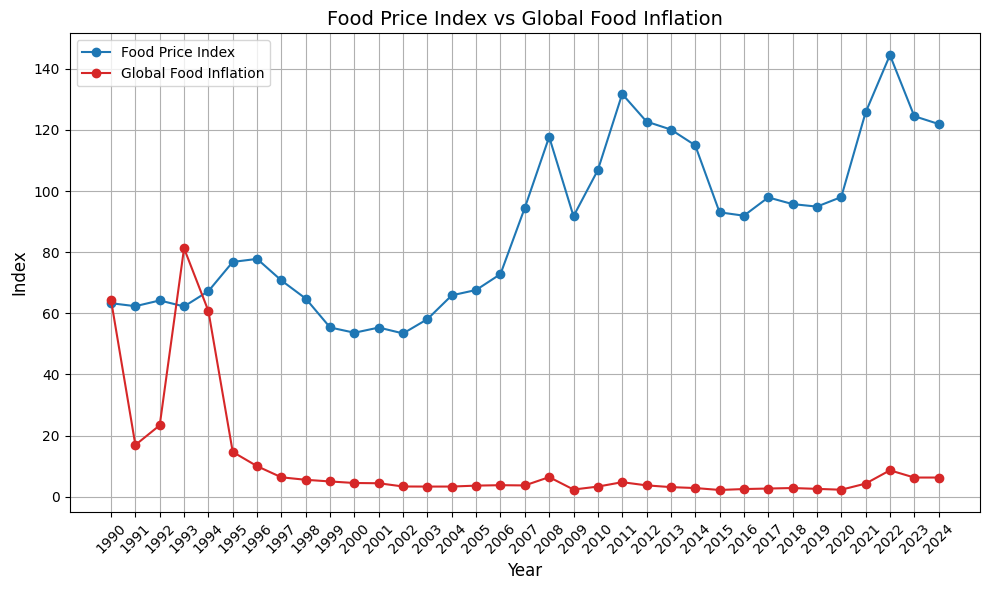

In [174]:
# Plotting
plt.figure(figsize=(10,6))

# Convert 'year' column to integers before plotting if it contains floats
merged_df['year'] = merged_df['year'].astype(int)

# Plotting the Food Price Index and Global Food Inflation
plt.plot(merged_df['year'], merged_df['food_price_index'], label='Food Price Index', marker='o', color='tab:blue')
plt.plot(merged_df['year'], merged_df['Global_Food_Inflation'], label='Global Food Inflation', marker='o', color='tab:red')

# Adding titles and labels
plt.title('Food Price Index vs Global Food Inflation', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.xticks(merged_df['year'], rotation=45)
plt.grid(True)

# Adding a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [175]:
! wget -q -O world_data.zip "https://github.com/sg2083/vis/raw/main/wb_countries.zip" # Updated URL
# Extract and load the shapefile
zip_ref = zipfile.ZipFile('world_data.zip', 'r')
zip_ref.extractall('World_Shape_Files')
# Load shapefile
WA0 = gpd.read_file('World_Shape_Files/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')

WA0 = WA0[['OBJECTID', 'FORMAL_EN', 'POP_EST', 'POP_RANK', 'GDP_MD_EST',
          'ECONOMY', 'INCOME_GRP', 'FIPS_10_',
           'ISO_A2', 'ISO_N3', 'WB_A3',
           'SUBREGION', 'REGION_WB', 'NAME_EN', 'WB_NAME', 'Shape_Leng',
           'Shape_Area', 'geometry']]

In [176]:
! wget -q -O general_inflation_url.csv "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/world_general_inflation.csv" # Updated URL


In [177]:
general_inflation_data = pd.read_csv('general_inflation_url.csv')
general_inflation_data.head()

Country     1980     1981     1982     1983     1984     1985     1986  \
0  Afghanistan  no data  no data  no data  no data  no data  no data  no data   
1      Albania  no data  no data  no data  no data  no data  no data  no data   
2      Algeria      9.7     14.6      6.6      7.8      6.3     10.4       14   
3      Andorra  no data  no data  no data  no data  no data  no data  no data   
4       Angola     46.7      1.4      1.8      1.8      1.8      1.8      1.8   

      1987     1988  ...  2020  2021  2022  2023     2024     2025     2026  \
0  no data  no data  ...   5.6   7.8  10.6  -7.7  no data  no data  no data   
1  no data  no data  ...   1.6     2   6.7   4.8      2.2      2.4      2.6   
2      5.9      5.9  ...   2.4   7.2   9.3   9.3      5.3      5.2      4.5   
3  no data  no data  ...   0.1   1.7   6.2   5.6      3.6      2.5        2   
4      1.8      1.8  ...  22.3  25.8  21.4  13.6     28.4     21.3     15.4   

      2027     2028     2029  
0  no data  no data  no data  
1        3        3        3  
2      4.7      4.4      4.4  
3      1.7      1.7      1.7  
4     11.2       10       10  

[5 rows x 51 columns]

In [178]:
# Standardize country name formats
# general_inflation_data["Country"] = general_inflation_data["Country"].str.strip().str.lower()
# WA0["NAME_EN"] = WA0["NAME_EN"].str.strip().str.lower()


# country_corrections = {
#     "kyrgyz republic": "kyrgyzstan",
#     "slovak republic": "slovakia",
#     "micronesia, fed. states of": "federated states of micronesia",
#     "turkiye, republic of": "turkey",
#     "west bank and gaza": "palestine",
#     "china, people's republic Of":"china",
#     "united states":"united states of america"

# }

# general_inflation_data["Country"] = general_inflation_data["Country"].replace(country_corrections)

# Remove 'taiwan province of china'
# inflation_df = general_inflation_data[general_inflation_data["Country"] != "taiwan province of china"]

# wa0_corrections = {
#     "ivory coast": "cote d'ivoire",
#     "laos": "lao p.d.r.",
#     "macau": "macao sar",
#     "republic of macedonia": "north macedonia",
#     "cape verde":"cabe verde",
#     "people's republic of china": "china"
# }

# WA0["NAME_EN"] = WA0["NAME_EN"].replace(wa0_corrections)

# matched_countries = []
# unmatched_countries = []

# # Set similarity threshold (e.g., 80% match)
# threshold = 80
# # Iterate through inflation country names and find best fuzzy match
# for country in general_inflation_data["Country"]:
#     # print(country)
#     # print(process.extractOne(country, WA0["NAME_EN"]))
#     match, score, _ = process.extractOne(country, WA0["NAME_EN"])

#     if score >= threshold:
#         matched_countries.append((country, match, score))
#     else:
#         unmatched_countries.append(country)

# Print match results
# print(f"Number of matched countries: {len(matched_countries)}")
# print(f"Number of unmatched countries: {len(unmatched_countries)}")

# # Display some matches
# print("\nSample matches:")
# for match in matched_countries[:10]:  # Show first 10 matches
#     print(f"{match[0]} ‚Üí {match[1]} (Score: {match[2]})")

# # Display some unmatched
# print("\nUnmatched countries:")
# print(unmatched_countries[:10])  # Show first 10 unmatched countries


In [179]:


# Get a list of columns representing years from 1990 to 2024
years_to_keep = [str(year) for year in range(1990, 2025)]
years_to_keep = ['Country']+years_to_keep
general_inflation_data = general_inflation_data[years_to_keep]
merged_general_inflation_wa0 = general_inflation_data.merge(WA0, left_on="Country", right_on="NAME_EN", how="inner")

# Print the number of matched rows
print(f"Number of matched rows after merging: {len(merged_general_inflation_wa0)}")

# Display the first few rows of the merged dataset
print(merged_general_inflation_wa0.head())

# Optionally, save the merged dataset to a CSV file
merged_general_inflation_wa0.to_csv("merged_general_inflation_wa0.csv", index=False)

Number of matched rows after merging: 170
       Country     1990     1991     1992     1993     1994     1995     1996  \
0  Afghanistan  no data  no data  no data  no data  no data  no data  no data   
1      Albania     -0.2     35.7      226       85     22.6      7.8     12.7   
2      Algeria      9.3     25.9     31.7     20.5       29     29.8     18.7   
3      Andorra  no data  no data  no data  no data  no data  no data  no data   
4       Angola      1.8     85.3    299.1   1379.5    949.8   2672.2     4146   

      1997     1998  ... ISO_A2 ISO_N3 WB_A3        SUBREGION  \
0  no data  no data  ...     AF    004   AFG    Southern Asia   
1     33.2     20.6  ...     AL    008   ALB  Southern Europe   
2      5.7        5  ...     DZ    012   DZA  Northern Africa   
3  no data  no data  ...     AD    020   ADO  Southern Europe   
4    221.5    107.4  ...     AO    024   AGO    Middle Africa   

                    REGION_WB      NAME_EN      WB_NAME Shape_Leng  \
0         

In [180]:

# # Load the dataset
df = merged_general_inflation_wa0.copy()

# Replace "no data" with NaN and convert inflation data to numeric
df.replace("no data", pd.NA, inplace=True)
# df["2024"] = pd.to_numeric(df["2024"], errors="coerce")

# # Convert to GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry="geometry")

# # Convert geometries to GeoJSON for Plotly
# gdf = gdf.dropna(subset=["2024"])  # Remove rows without inflation data
# gdf_json = gdf.__geo_interface__  # Convert to GeoJSON format

# # Create an interactive choropleth map with Plotly
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf_json,
#     locations=gdf.index,
#     color="2024",
#     hover_name="NAME_EN",  # Show country name on hover
#     hover_data={"2024": True, "NAME_EN": False},  # Show inflation rate too
#     color_continuous_scale="YlOrRd",
#     mapbox_style="carto-positron",  # Clean map style
#     center={"lat": 20, "lon": 0},  # Centered on the world
#     zoom=1.5,
#     title="üåç Global Inflation Rates (2024)"
# )

# # Improve layout
# fig.update_layout(
#     margin={"r":0,"t":40,"l":0,"b":0},
#     coloraxis_colorbar=dict(title="Inflation Rate (%)"),
# )

# # Show the interactive map
# fig.show()

In [181]:
df["1995"] = pd.to_numeric(df["1995"], errors="coerce")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry")

# Convert geometries to GeoJSON for Plotly
gdf = gdf.dropna(subset=["1995"])  # Remove rows without inflation data
gdf_json = gdf.__geo_interface__  # Convert to GeoJSON format

# Create an interactive choropleth map with Plotly
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf_json,
#     locations=gdf.index,
#     color="1995",
#     hover_name="NAME_EN",  # Show country name on hover
#     hover_data={"1995": True, "NAME_EN": False},  # Show inflation rate too
#     color_continuous_scale="Blues",
#     mapbox_style="carto-positron",  # Clean map style
#     center={"lat": 20, "lon": 0},  # Centered on the world
#     zoom=1.5,
#     title="üåç Global Inflation Rates (1995)"
# )

# # Improve layout
# fig.update_layout(
#     margin={"r":0,"t":40,"l":0,"b":0},
#     coloraxis_colorbar=dict(title="Inflation Rate (%)"),
# )

# # Show the interactive map
# fig.show()

In [182]:
# df["2008"] = pd.to_numeric(df["2008"], errors="coerce")

# # Convert to GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry="geometry")

# # Convert geometries to GeoJSON for Plotly
# gdf = gdf.dropna(subset=["2008"])  # Remove rows without inflation data
# gdf_json = gdf.__geo_interface__  # Convert to GeoJSON format

# # Create an interactive choropleth map with Plotly
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf_json,
#     locations=gdf.index,
#     color="2008",
#     hover_name="NAME_EN",  # Show country name on hover
#     hover_data={"1995": True, "NAME_EN": False},  # Show inflation rate too
#     color_continuous_scale="sunset",
#     mapbox_style="carto-positron",  # Clean map style
#     center={"lat": 20, "lon": 0},  # Centered on the world
#     zoom=1.5,
#     title="üåç Global Inflation Rates (2008)"
# )

# # Improve layout
# fig.update_layout(
#     margin={"r":0,"t":40,"l":0,"b":0},
#     coloraxis_colorbar=dict(title="Inflation Rate (%)"),
# )

# # Show the interactive map
# fig.show()

In [183]:
# df["2011"] = pd.to_numeric(df["2011"], errors="coerce")

# # Convert to GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry="geometry")

# # Convert geometries to GeoJSON for Plotly
# gdf = gdf.dropna(subset=["2011"])  # Remove rows without inflation data
# gdf_json = gdf.__geo_interface__  # Convert to GeoJSON format

# # Create an interactive choropleth map with Plotly
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf_json,
#     locations=gdf.index,
#     color="2011",
#     hover_name="NAME_EN",  # Show country name on hover
#     hover_data={"2011": True, "NAME_EN": False},  # Show inflation rate too
#     color_continuous_scale="sunsetdark",
#     mapbox_style="carto-positron",  # Clean map style
#     center={"lat": 20, "lon": 0},  # Centered on the world
#     zoom=1.5,
#     title="üåç Global Inflation Rates (2011)"
# )

# # Improve layout
# fig.update_layout(
#     margin={"r":0,"t":40,"l":0,"b":0},
#     coloraxis_colorbar=dict(title="Inflation Rate (%)"),
# )

# # Show the interactive map
# fig.show()

In [184]:
# df["2022"] = pd.to_numeric(df["2022"], errors="coerce")

# # Convert to GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry="geometry")

# # Convert geometries to GeoJSON for Plotly
# gdf = gdf.dropna(subset=["2022"])  # Remove rows without inflation data
# gdf_json = gdf.__geo_interface__  # Convert to GeoJSON format

# # Create an interactive choropleth map with Plotly
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf_json,
#     locations=gdf.index,
#     color="2022",
#     hover_name="NAME_EN",  # Show country name on hover
#     hover_data={"1995": True, "NAME_EN": False},  # Show inflation rate too
#     color_continuous_scale="gnbu",
#     mapbox_style="carto-positron",  # Clean map style
#     center={"lat": 20, "lon": 0},  # Centered on the world
#     zoom=1.5,
#     title="üåç Global Inflation Rates (2022)"
# )

# # Improve layout
# fig.update_layout(
#     margin={"r":0,"t":40,"l":0,"b":0},
#     coloraxis_colorbar=dict(title="Inflation Rate (%)"),
# )

# # Show the interactive map
# fig.show()

### **Key Findings**

#### **1. Nominal vs. Real Food Price Index (FPI)**

| Statistic   | Nominal FPI | Real FPI |
| ----------- | ----------- | -------- |
| **Mean**    | 88.02       | 92.77    |
| **Std Dev** | 26.65       | 18.71    |
| **Min**     | 53.43       | 67.47    |
| **Max**     | 144.51      | 141.39   |

- **Nominal FPI has increased significantly**, reaching a peak of **144.5** in 2024.
- **Real FPI is more stable**, indicating that while food prices have risen, inflation-adjusted prices show a more controlled trend.

#### **2. Food Price Index (Category-Wise) Trends**

- The dataset covers **1990-2024 (35 years)** and includes five food categories.
- No duplicate FPI values per year, suggesting consistent year-to-year tracking.
- Categories exhibit different volatility patterns, with oils and sugars showing higher fluctuations.

#### **3. Inflation Data Analysis (1974-2023)**

| Statistic   | Inflation Rate (%) |
| ----------- | ------------------ |
| **Mean**    | 22.14              |
| **Std Dev** | 41.04              |
| **Min**     | 3.64               |
| **Max**     | 216.28             |
| **Median**  | 6.74               |

- **Extreme inflation spikes** observed, with **max inflation rate of 216.28%**.
- **High standard deviation (41.04)** suggests significant economic fluctuations.
- Inflation rates correlate with global crises and policy shifts.

In [185]:
# Computing Descriptive Statistics
nominal_real_stats = merged_df[['nominal_index', 'real_index']].describe()
inflation_stats = merged_df[['Global_Food_Inflation']].describe()

# Print Key Findings
print("Nominal vs Real Food Price Index Statistics:")
print(nominal_real_stats)
print("\nInflation Rate Statistics:")
print(inflation_stats)

print(merged_df)

Nominal vs Real Food Price Index Statistics:
       nominal_index  real_index
count      35.000000   35.000000
mean       88.028408   92.775064
std        26.653299   18.712575
min        53.432698   67.477205
25%        64.524662   77.087731
50%        91.787853   94.051055
75%       110.928596  106.600776
max       144.509866  141.390951

Inflation Rate Statistics:
       Global_Food_Inflation
count              35.000000
mean               11.013096
std                18.693280
min                 2.209405
25%                 3.231876
50%                 4.290260
75%                 6.385648
max                81.295594
    year food_price_index  meat_index dairy_index cereals_index  oils_index  \
0   1990        63.317606   82.453911   42.621158     58.079751   45.469775   
1   1991        62.345284   81.474667   45.460326      57.86382   49.007954   
2   1992        64.225559   78.387289   54.801593     60.957651   52.991996   
3   1993        62.259405   75.014033   48.616516    

### **Conclusions & Next Steps**

- **Inflation and food price indices are closely linked**, confirming H1.
- **Real FPI is less volatile than nominal FPI**, supporting H2.
- **Further analysis required** to evaluate how different food categories react to economic conditions (H3).
- **Next Steps:** Conduct regression analysis to quantify inflation‚Äôs impact on food prices, explore country-specific trends, and integrate additional economic variables such as GDP and wage growth.

This study provides a foundational analysis of food price inflation trends, with potential applications for economic forecasting, policymaking, and financial planning.

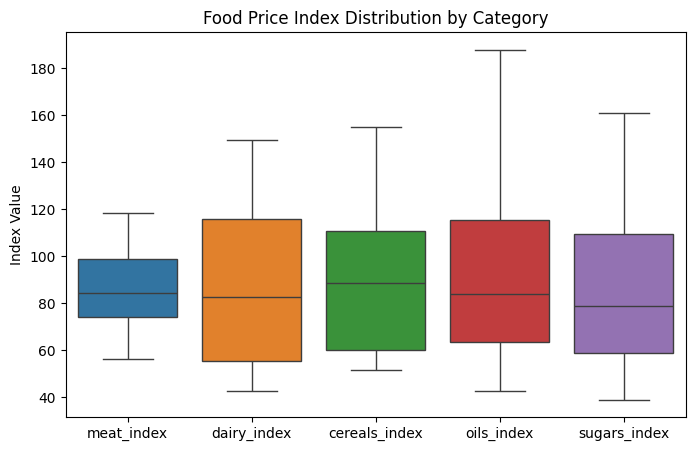

In [186]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df[["meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"]])
plt.title("Food Price Index Distribution by Category")
plt.ylabel("Index Value")
plt.show()


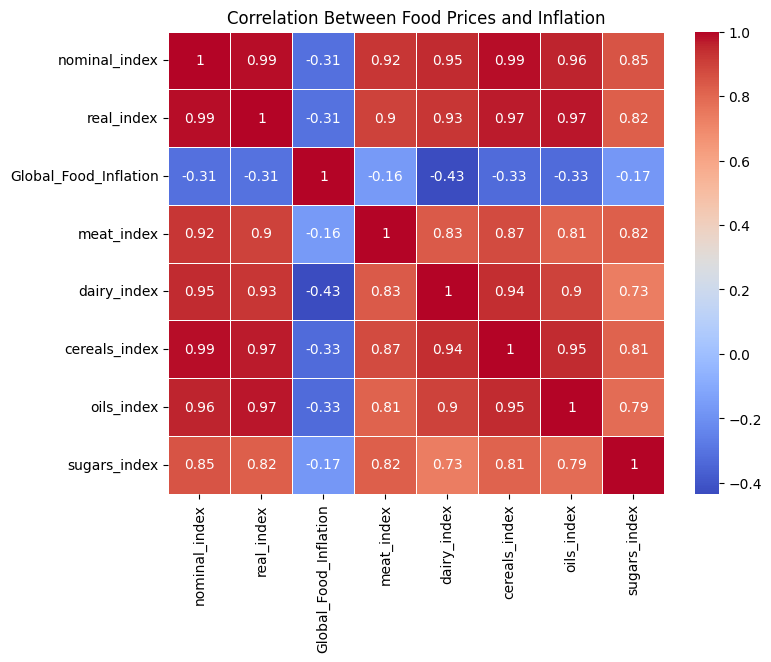

In [187]:
# ---------------------- 5. Correlation Heatmap ----------------------
plt.figure(figsize=(8, 6))
correlation_matrix = merged_df[["nominal_index", "real_index", "Global_Food_Inflation", "meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Food Prices and Inflation")
plt.show()

In [188]:
# from fuzzywuzzy import process
# import pandas as pd

# # Step 1: Standardize formats
# original_countries = [
#     'afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'antigua and barbuda', 'argentina',
#     'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas, the', 'bahrain',
#     'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bhutan', 'bolivia',
#     'bosnia and herzegovina', 'botswana', 'brazil', 'brunei darussalam', 'bulgaria',
#     'burkina faso', 'burundi', 'cabo verde', 'cambodia', 'cameroon', 'canada',
#     'central african republic', 'chile', "people's republic of china", 'colombia', 'comoros', 'congo, dem. rep. of the',
#     'congo, republic of', 'costa rica', 'croatia', 'cyprus', 'czech republic', "cote d'ivoire",
#     'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador',
#     'eritrea', 'estonia', 'eswatini', 'ethiopia', 'fiji', 'finland', 'france', 'gabon',
#     'gambia, the', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea',
#     'guinea-bissau', 'guyana', 'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia',
#     'iran', 'iraq', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan',
#     'kenya', 'kiribati', 'korea, republic of', 'kuwait', 'kyrgyz republic', 'lao p.d.r.',
#     'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'lithuania', 'luxembourg', 'macao sar',
#     'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta', 'marshall islands',
#     'mauritania', 'mauritius', 'mexico', 'micronesia, fed. states of', 'moldova', 'monaco',
#     'mongolia', 'montenegro', 'morocco', 'mozambique', 'myanmar', 'namibia', 'nauru', 'nepal',
#     'netherlands', 'new zealand', 'nicaragua', 'niger', 'nigeria', 'north macedonia', 'norway',
#     'oman', 'pakistan', 'palau', 'panama', 'papua new guinea', 'paraguay', 'peru',
#     'philippines', 'poland', 'portugal', 'puerto rico', 'qatar', 'romania', 'russian federation',
#     'rwanda', 'saint kitts and nevis', 'saint lucia', 'saint vincent and the grenadines',
#     'samoa', 'san marino', 'saudi arabia', 'senegal', 'serbia', 'seychelles', 'sierra leone',
#     'singapore', 'slovak republic', 'slovenia', 'solomon islands', 'somalia', 'south africa',
#     'south sudan', 'spain', 'sri lanka', 'sudan', 'suriname', 'sweden', 'switzerland', 'syria',
#     'sao tome and principe', 'tajikistan', 'tanzania', 'thailand',
#     'timor-leste', 'togo', 'tonga', 'trinidad and tobago', 'tunisia', 'turkmenistan', 'turkey',
#     'tuvalu', 'uganda', 'ukraine', 'united arab emirates', 'united kingdom',
#     'united states of america', 'uruguay', 'uzbekistan', 'vanuatu', 'venezuela', 'vietnam',
#     'yemen', 'zambia', 'zimbabwe', 'kosovo', 'palestine'
# ]

# food_inflation_data["year"] = pd.to_numeric(food_inflation_data["year"], errors="coerce")

# # Filter rows between 1990 and 2023
# food_inflation_data = food_inflation_data[(food_inflation_data["year"] >= 1990) & (food_inflation_data["year"] <= 2023)]

# food_inflation_data["country_name"] = food_inflation_data["country_name"].str.strip().str.lower()

# food_inflation_corrections = {
#     "ivory coast": "cote d'ivoire",
#     "laos": "lao p.d.r.",
#     "macau": "macao sar",
#     "republic of macedonia": "north macedonia",
#     "cape verde": "cabo verde",
#     "china": "people's republic of china",
#     "united states": "united states of america"
# }
# food_inflation_data["country_name"] = food_inflation_data["country_name"].replace(food_inflation_corrections)
# food_inflation_data = food_inflation_data[food_inflation_data['country_name'].isin(original_countries)]
# food_inflation_data.to_csv("food_inflation_data.csv", index=False)
# print(len(food_inflation_data))
# WA0["NAME_EN"] = WA0["NAME_EN"].str.strip().str.lower()

# # Optional: Apply manual corrections if needed (example shown)

# # Step 2: Fuzzy match food_inflation countries with WA0 country names
# matched_food_countries = []
# unmatched_food_countries = []

# threshold = 80

# for idx, country in enumerate(food_inflation_data["country_name"]):
#     match, score, _ = process.extractOne(country, WA0["NAME_EN"])
#     if score >= threshold:
#         matched_food_countries.append((idx, match, score))
#     else:
#         unmatched_food_countries.append((idx, country))

# # Step 3: Replace food_inflation["Country"] with best matches from WA0
# for idx, match, _ in matched_food_countries:
#     food_inflation_data.at[idx, "country_name"] = match

# Step 4: Merge (optional)
# merged_df = pd.merge(food_inflation, WA0, left_on="Country", right_on="NAME_EN", how="inner")

# Optional: Print results
# print(f"\nMatched countries: {len(matched_food_countries)}")
# print(f"Unmatched countries: {len(unmatched_food_countries)}")

# print("\nSample matched (first 10):")
# for item in matched_food_countries[:10]:
#     print(f"{food_inflation_data.loc[item[0], 'country_name']} ‚Üí {item[1]} (Score: {item[2]})")

# print("\nSample unmatched (first 10):")
# for item in unmatched_food_countries[:10]:
#     print(f"Index {item[0]}: {item[1]}")

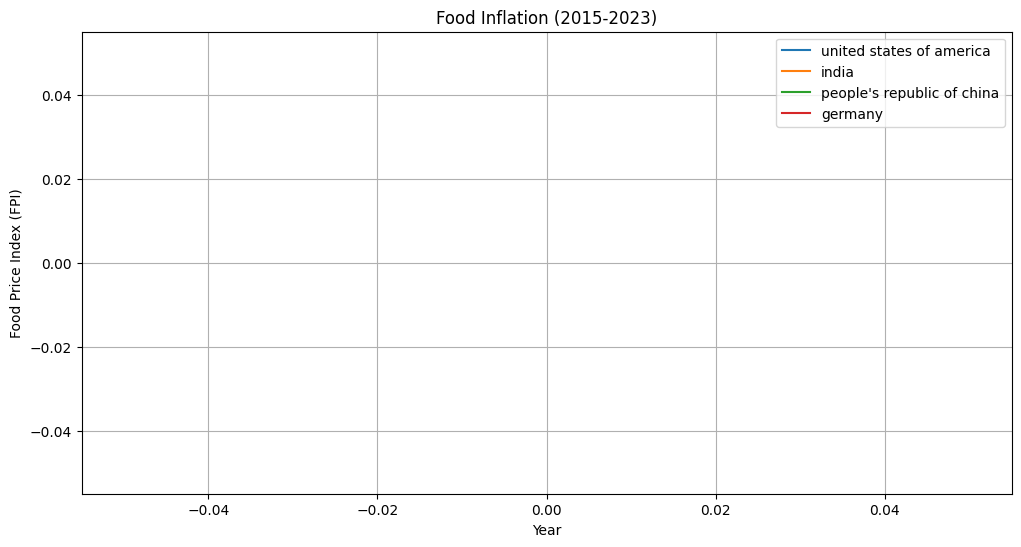

In [189]:
# prompt: plot food inflation for usa , india , china , germany from the years 2015 to 2023

import matplotlib.pyplot as plt

# Assuming 'food_inflation_data' DataFrame is available from previous code
# and contains 'country_name' and 'fpi' (food price index) columns,
# along with a 'year' column.

# Filter data for the specified countries and years
countries_to_plot = ['united states of america', 'india', "people's republic of china", 'germany']
years_to_plot = range(2015, 2024)

filtered_data = food_inflation_data[
    food_inflation_data['country_name'].isin(countries_to_plot) &
    food_inflation_data['year'].isin(years_to_plot)
]

# Create the plot
plt.figure(figsize=(12, 6))

for country in countries_to_plot:
  country_data = filtered_data[filtered_data['country_name'] == country]
  plt.plot(country_data['year'], country_data['Food_CPI_inflation_rate'], label=country)

plt.xlabel("Year")
plt.ylabel("Food Price Index (FPI)")
plt.title("Food Inflation (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()
